# 라이브러리

In [51]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore")

import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats

import theano
from theano import tensor as T
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import itertools
from sklearn.metrics import confusion_matrix
from collections import Counter

from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier

# Data Summary

In [52]:
df=pd.read_pickle("../LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [53]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [54]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


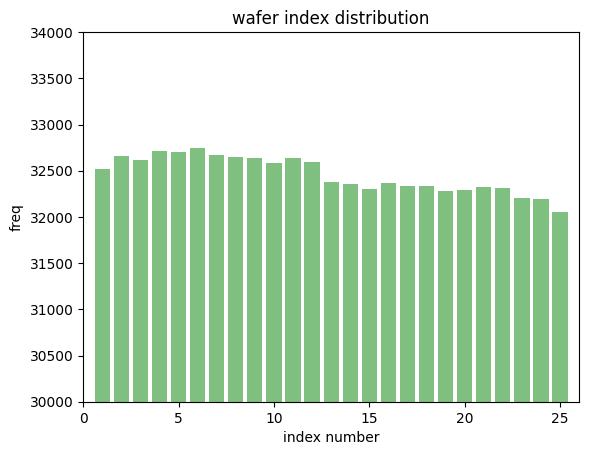

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='green', align='center', alpha=0.5)
plt.title("wafer index distribution")
plt.xlabel("index number")
plt.ylabel("freq")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [56]:
df=df.drop(['waferIndex'], axis=1)

In [57]:
def find_dim(x):
    dim0=np.size(x, axis=0)
    dim1=np.size(x, axis=1)
    return dim0, dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
772214,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1334.0,lot45945,[[Test]],[[none]],"(41, 42)"
545571,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot34090,[],[],"(49, 39)"
107556,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",845.0,lot7311,[],[],"(35, 31)"
246768,"[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 2, 0, 0,...",260.0,lot15421,[],[],"(18, 19)"
130887,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1109.0,lot8547,[],[],"(39, 37)"


In [58]:
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [59]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

632

In [60]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5,'Scratch':6, 'Near-full':7, 'none':8}
mapping_traintest={'Training':0, 'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [61]:
tol_wafers=df.shape[0] # 행 갯수 반환
tol_wafers

811457

In [62]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)] # 새로운 데이터 프레임 생성
df_withlabel = df_withlabel.reset_index() # 앞에서 생성한 데이터 프레임의 인덱스 재설정
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)] # 새로운 데이터 프레임 생성
df_withpattern = df_withpattern.reset_index() # 데이터 프레임 인덱스 재설정
df_nonpattern = df[(df['failureNum']==8)] # 새로운 데이터 프레임 생성
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0] # 각 데이터 프레임 행 갯수 반환

(172950, 25519, 147431)

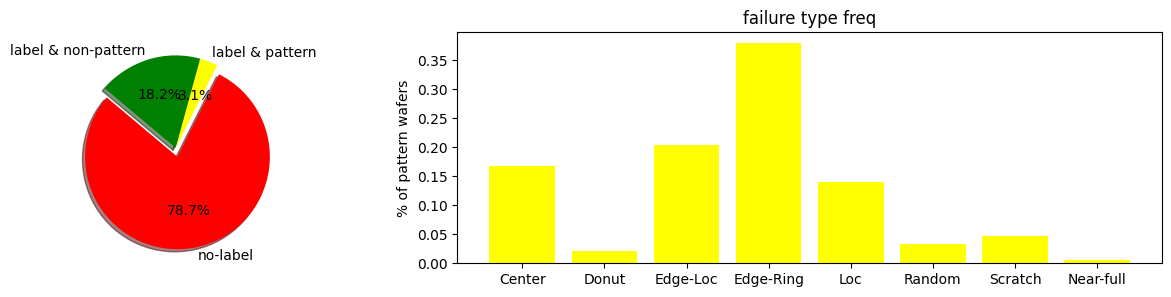

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
figure = plt.figure(figsize=(15,3))
gridspec = gridspec.GridSpec(1, 2, width_ratios=[1,2])
ax1 = plt.subplot(gridspec[0])
ax2 = plt.subplot(gridspec[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['red', 'yellow', 'green']
explode = (0.1, 0, 0)
labels = ['no-label', 'label & pattern', 'label & non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2=['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='yellow', align='center', alpha=1)
ax2.set_title("failure type freq")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

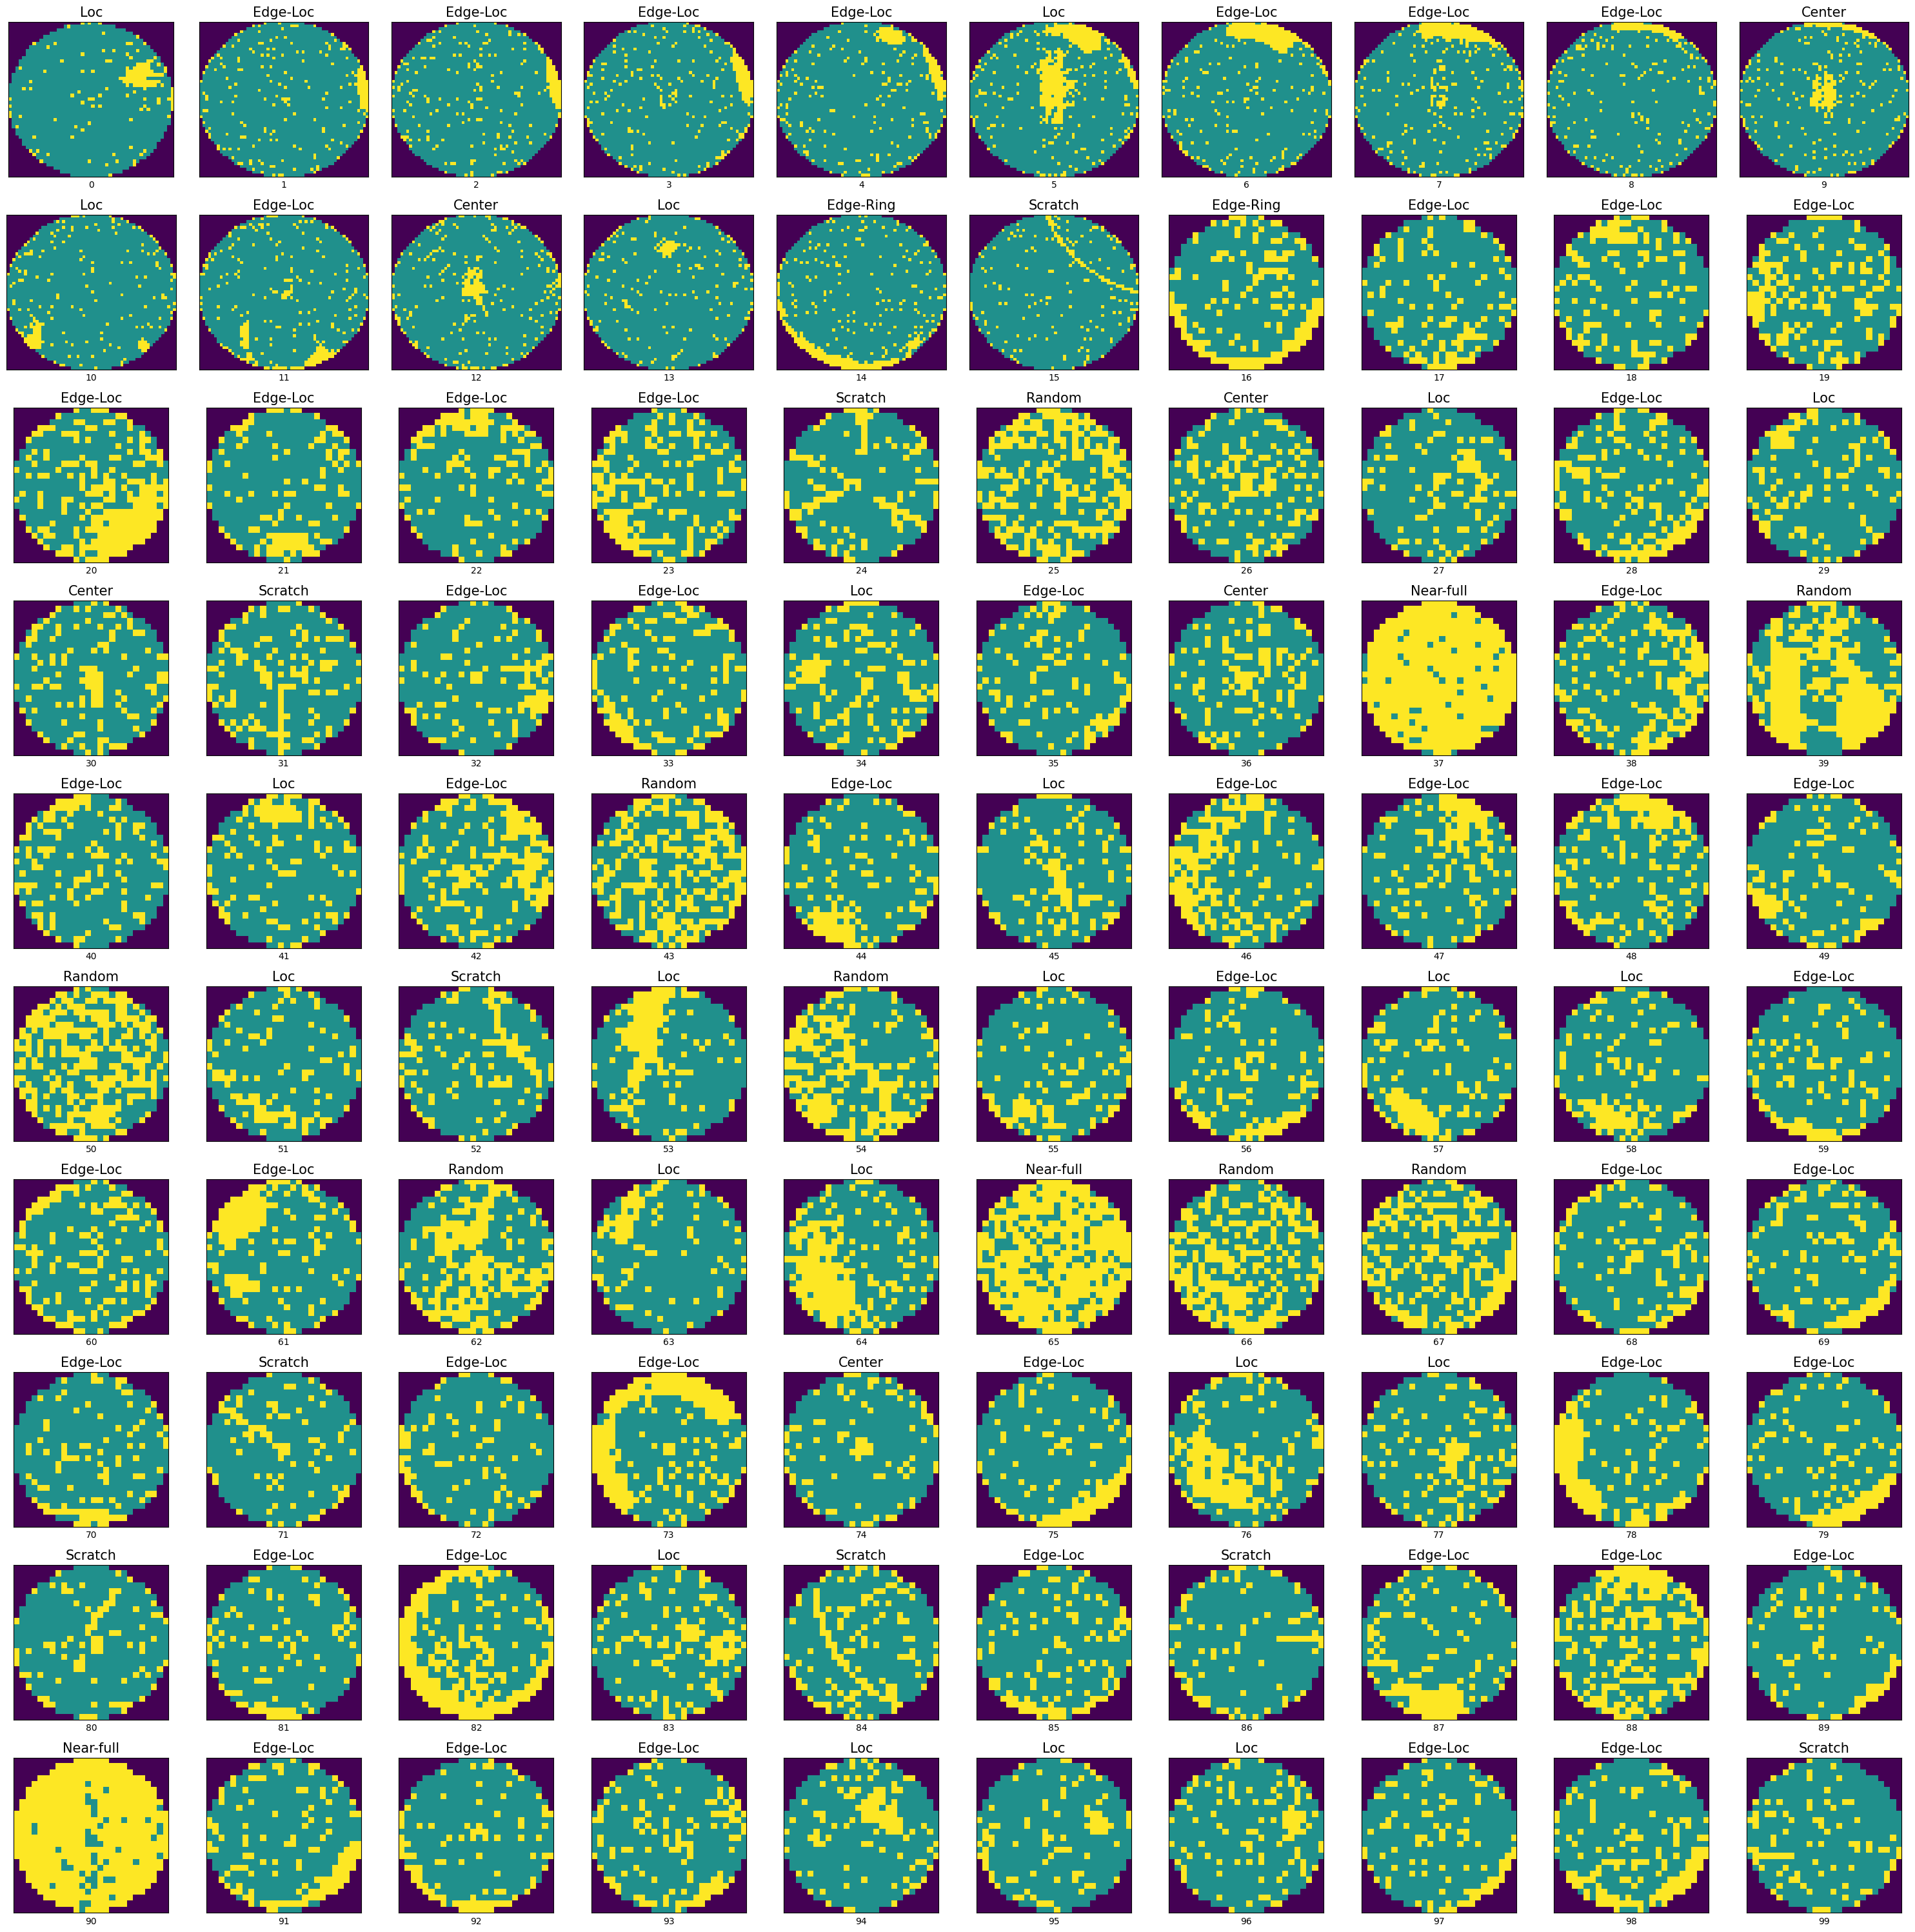

In [64]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(30, 30))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=15)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

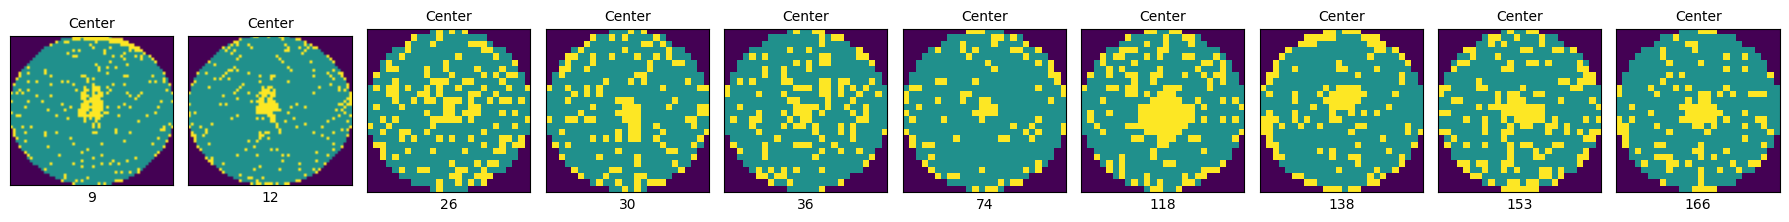

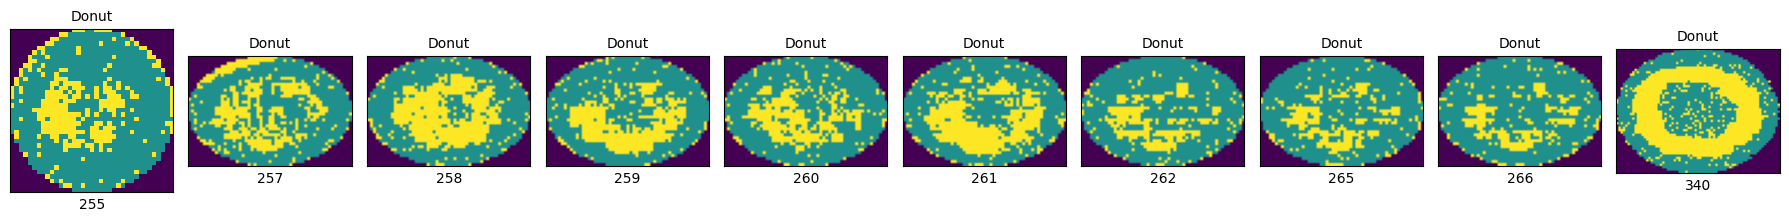

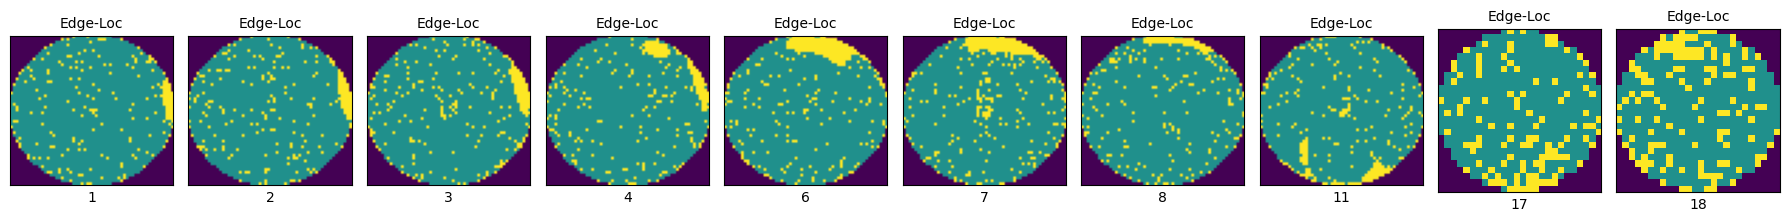

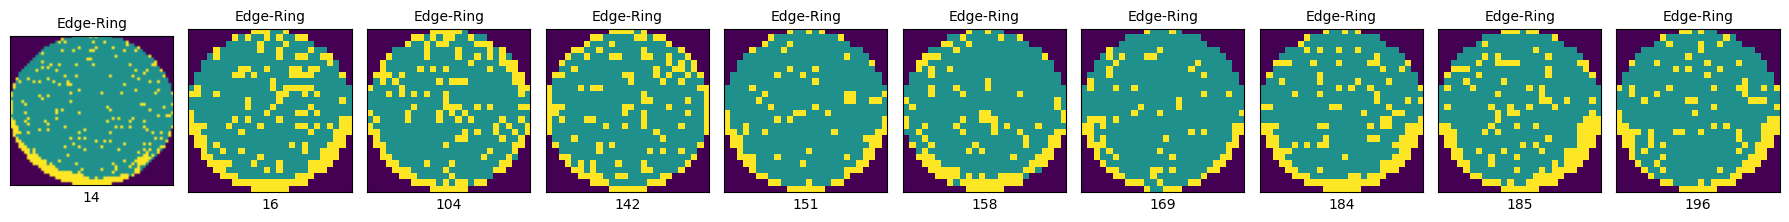

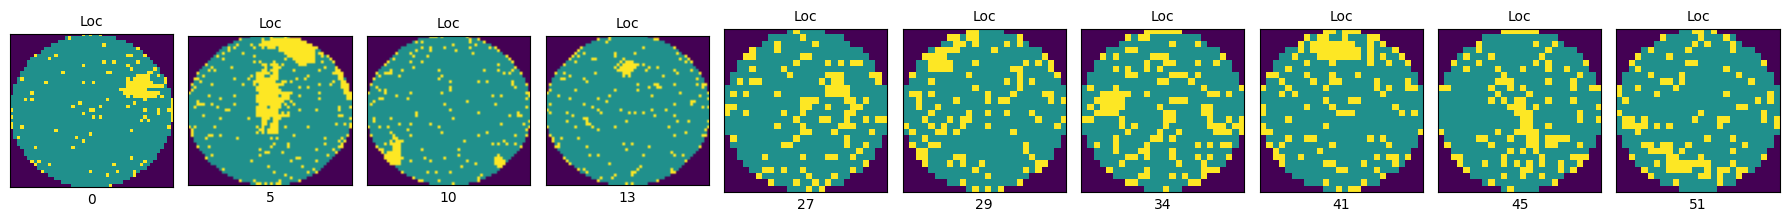

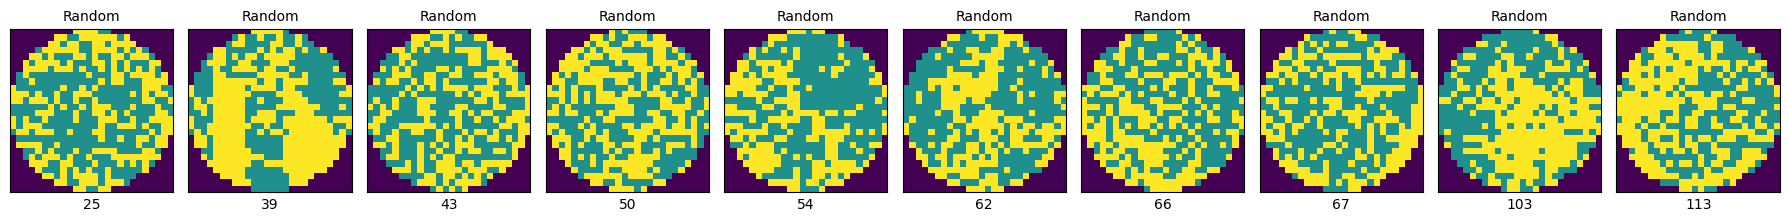

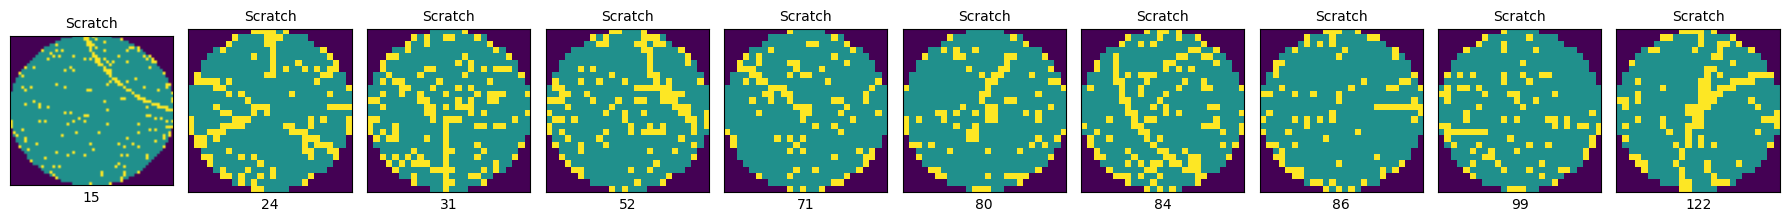

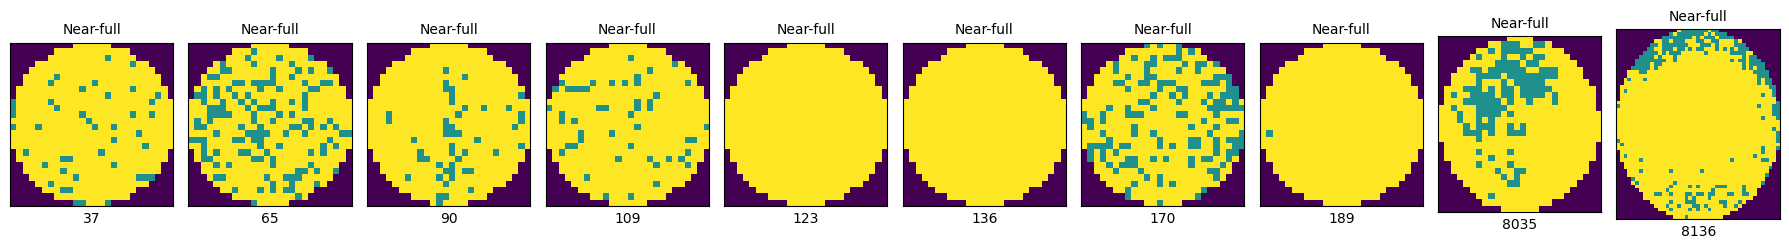

In [65]:
x=[0,1,2,3,4,5,6,7]
labels2=['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for i in x:
    fig, ax=plt.subplots(nrows=1, ncols=10, figsize=(18,12))
    ax=ax.ravel(order='C') # ravel은 다차원 배열을 1차원으로 변경, C는 기본값
    for j in [i]:
        img=df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]
        for k in range(10):
            ax[k].imshow(img[img.index[k]])
            ax[k].set_title(df_withpattern.failureType[img.index[k]][0][0], fontsize=10)
            ax[k].set_xlabel(df_withpattern.index[img.index[k]], fontsize=10)
            ax[k].set_xticks([])
            ax[k].set_yticks([])
    plt.tight_layout()
    plt.show()

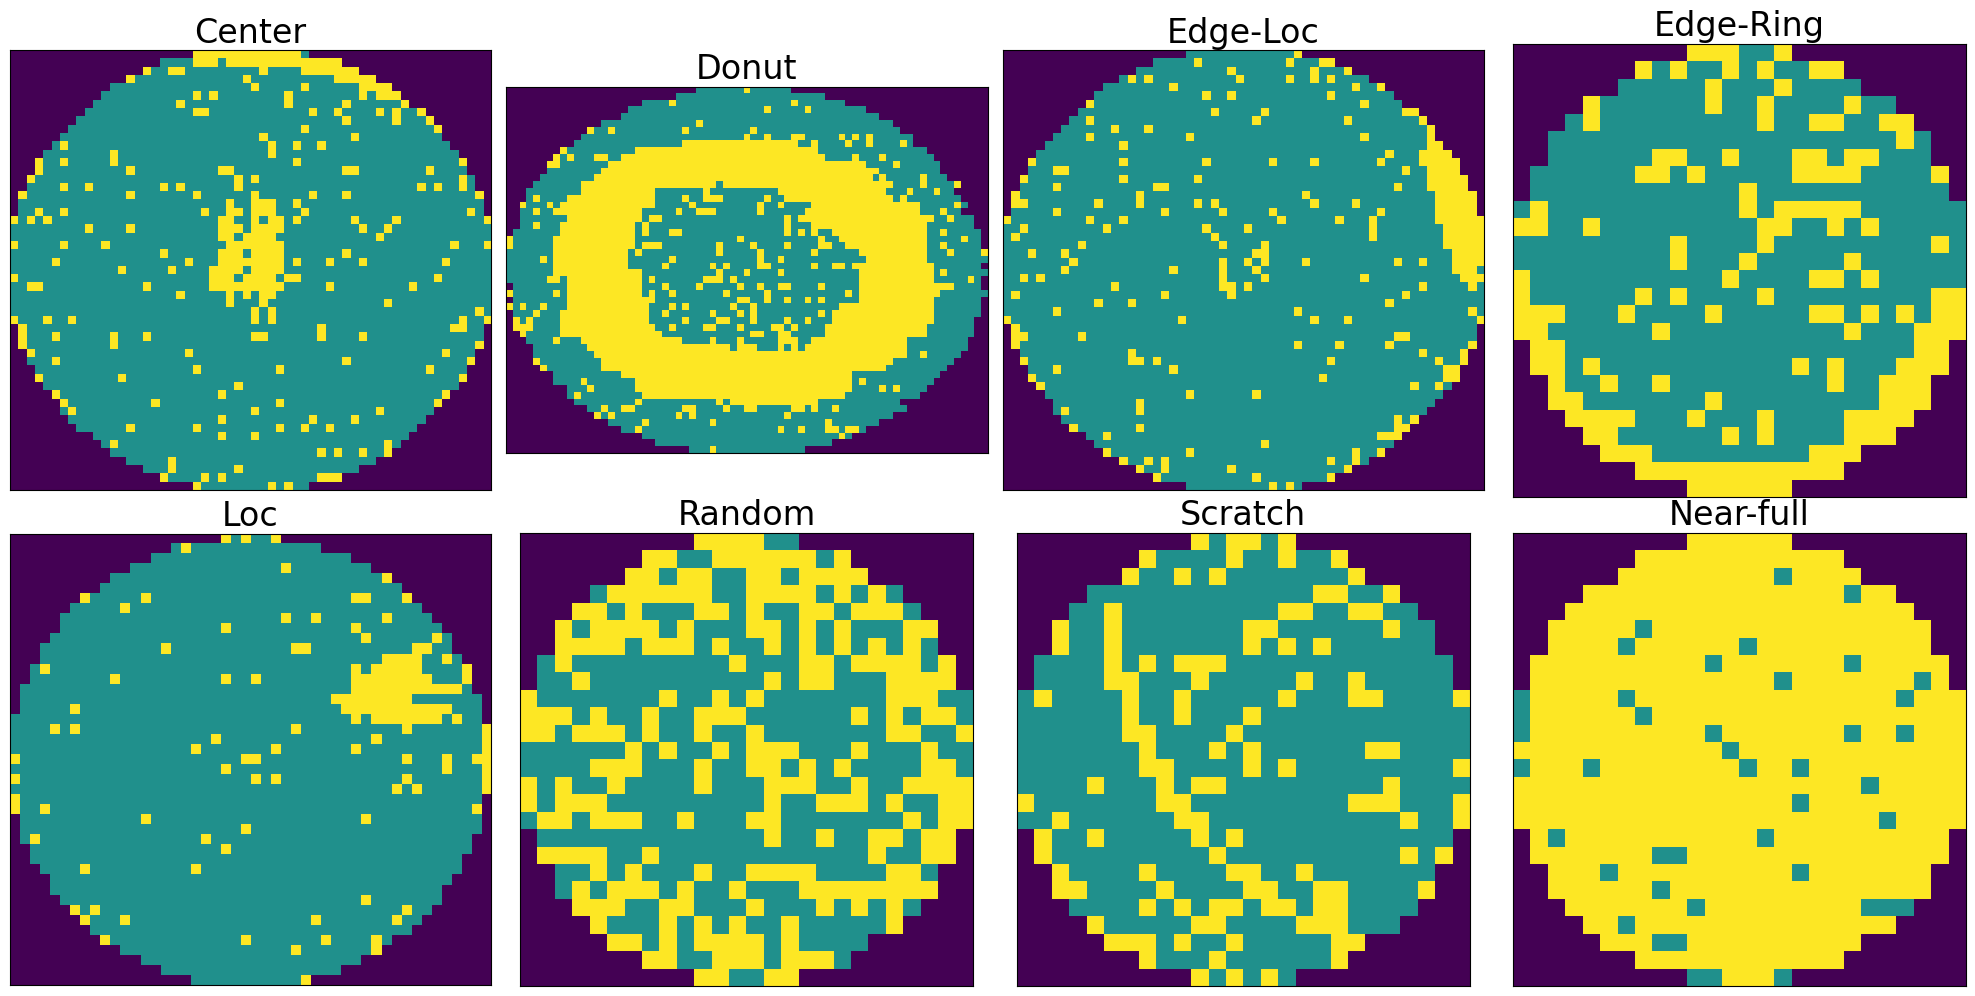

In [66]:
x=[9, 340, 3, 16, 0, 25, 84, 37]
labels2=['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig,ax=plt.subplots(nrows=2, ncols=4, figsize=(20,10))
ax=ax.ravel(order='C')
for i in range(8):
    img=df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0], fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

# Data transformation

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


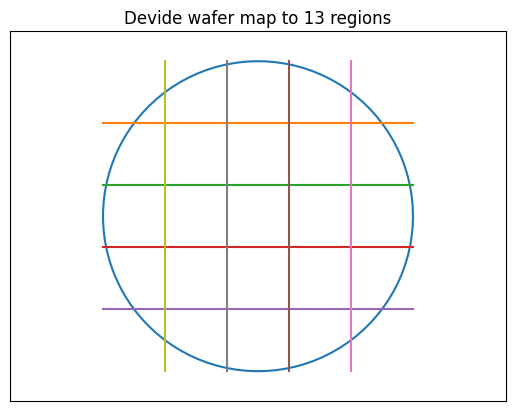

In [67]:
an=np.linspace(0, 2*np.pi, 100)
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))
plt.axis('equal')
plt.axis([-4,4,-4,4])
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])

plt.title("Devide wafer map to 13 regions")
plt.xticks([]) # 축 없애기
plt.yticks([])
plt.show()

In [68]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

In [69]:
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)

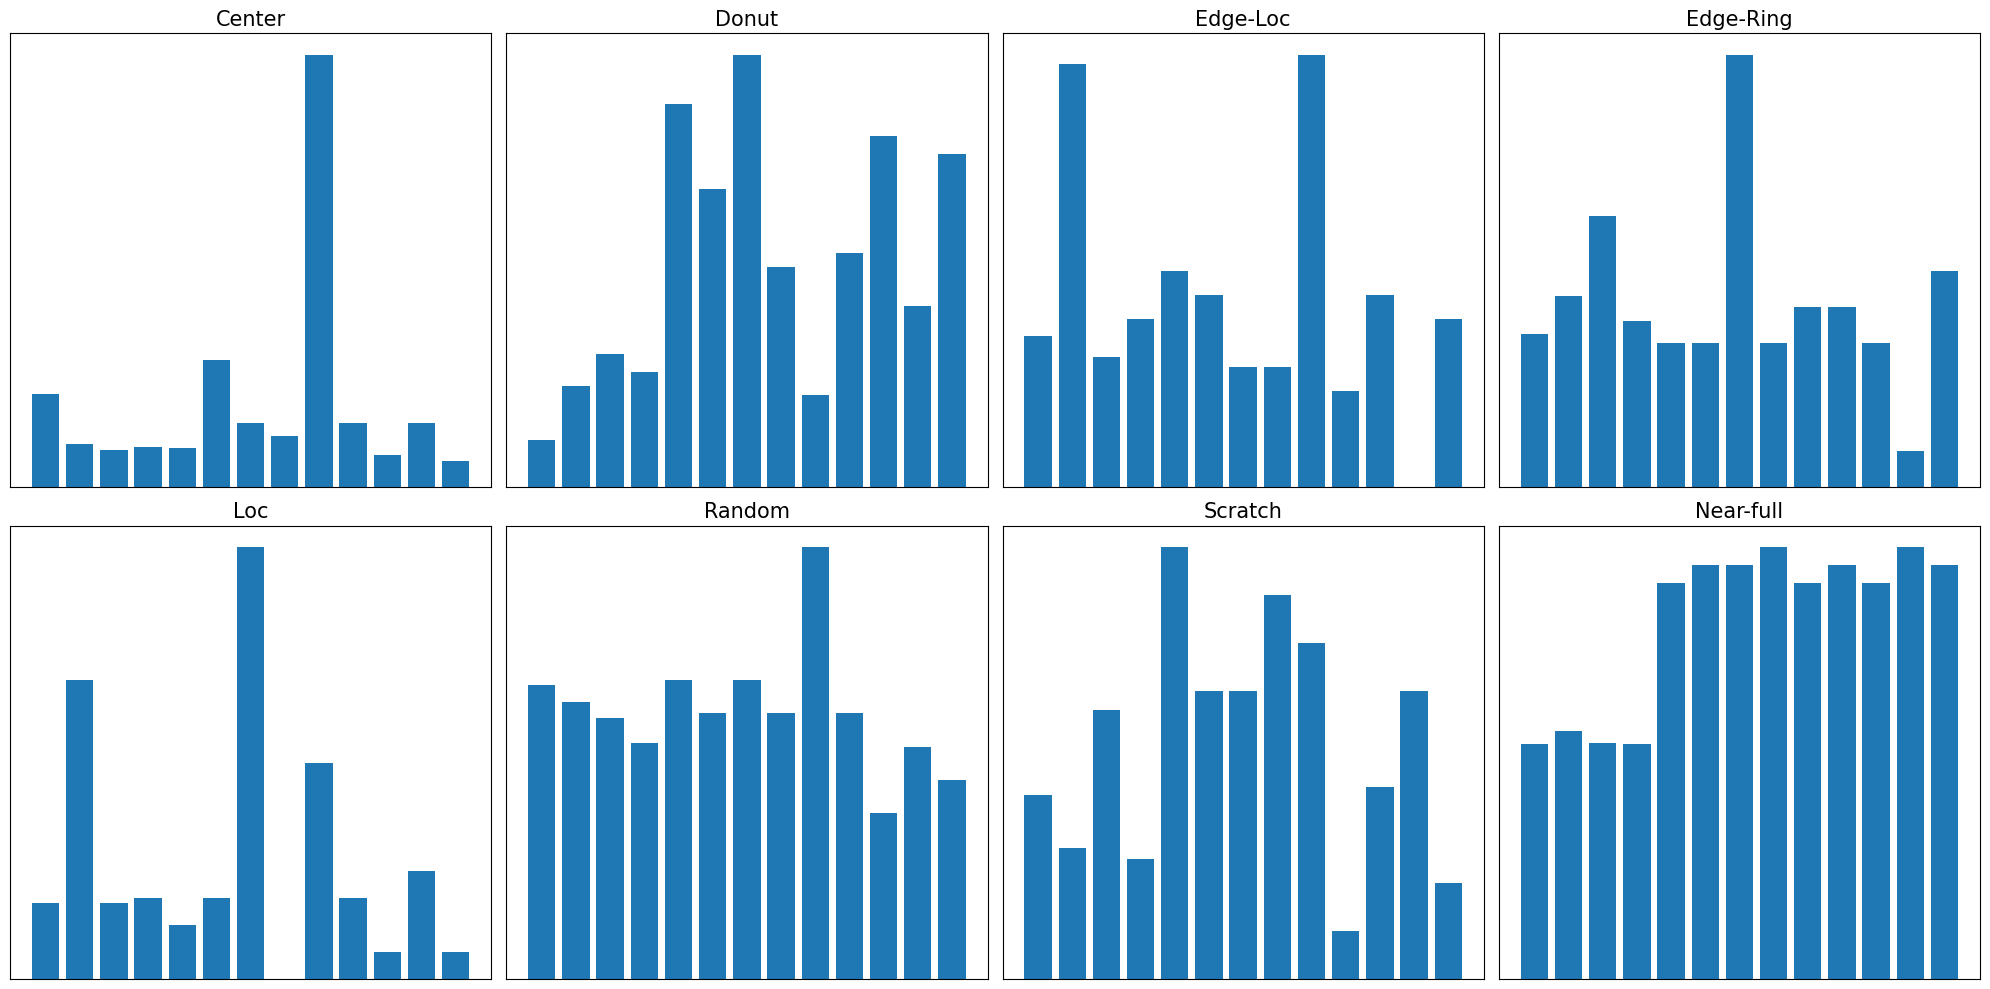

In [70]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,13,13),df_withpattern.fea_reg[x[i]])
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

In [71]:
def change_val(img):
    img[img==1] =0  
    return img

df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap'] =df_withpattern_copy.waferMap.apply(change_val)

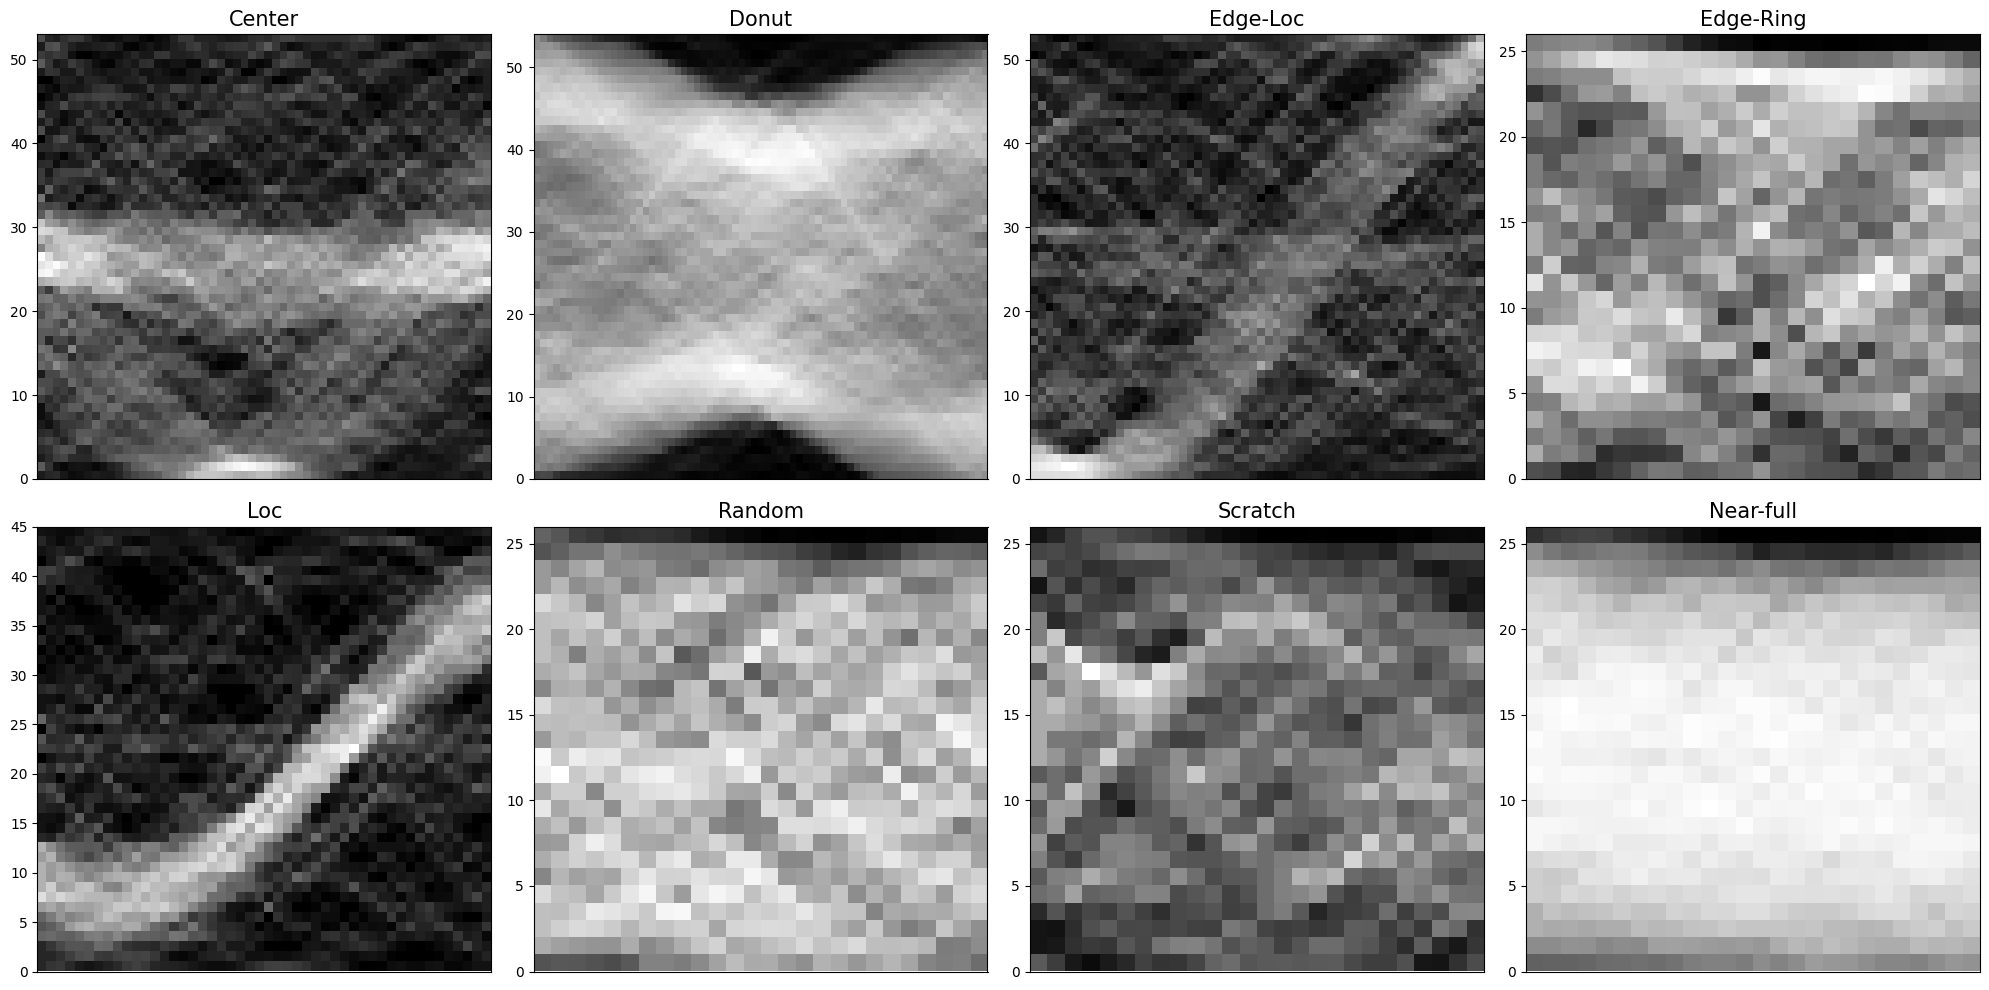

In [72]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    
      
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

In [73]:
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew  

In [74]:
df_withpattern_copy['fea_cub_mean'] =df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] =df_withpattern_copy.waferMap.apply(cubic_inter_std)

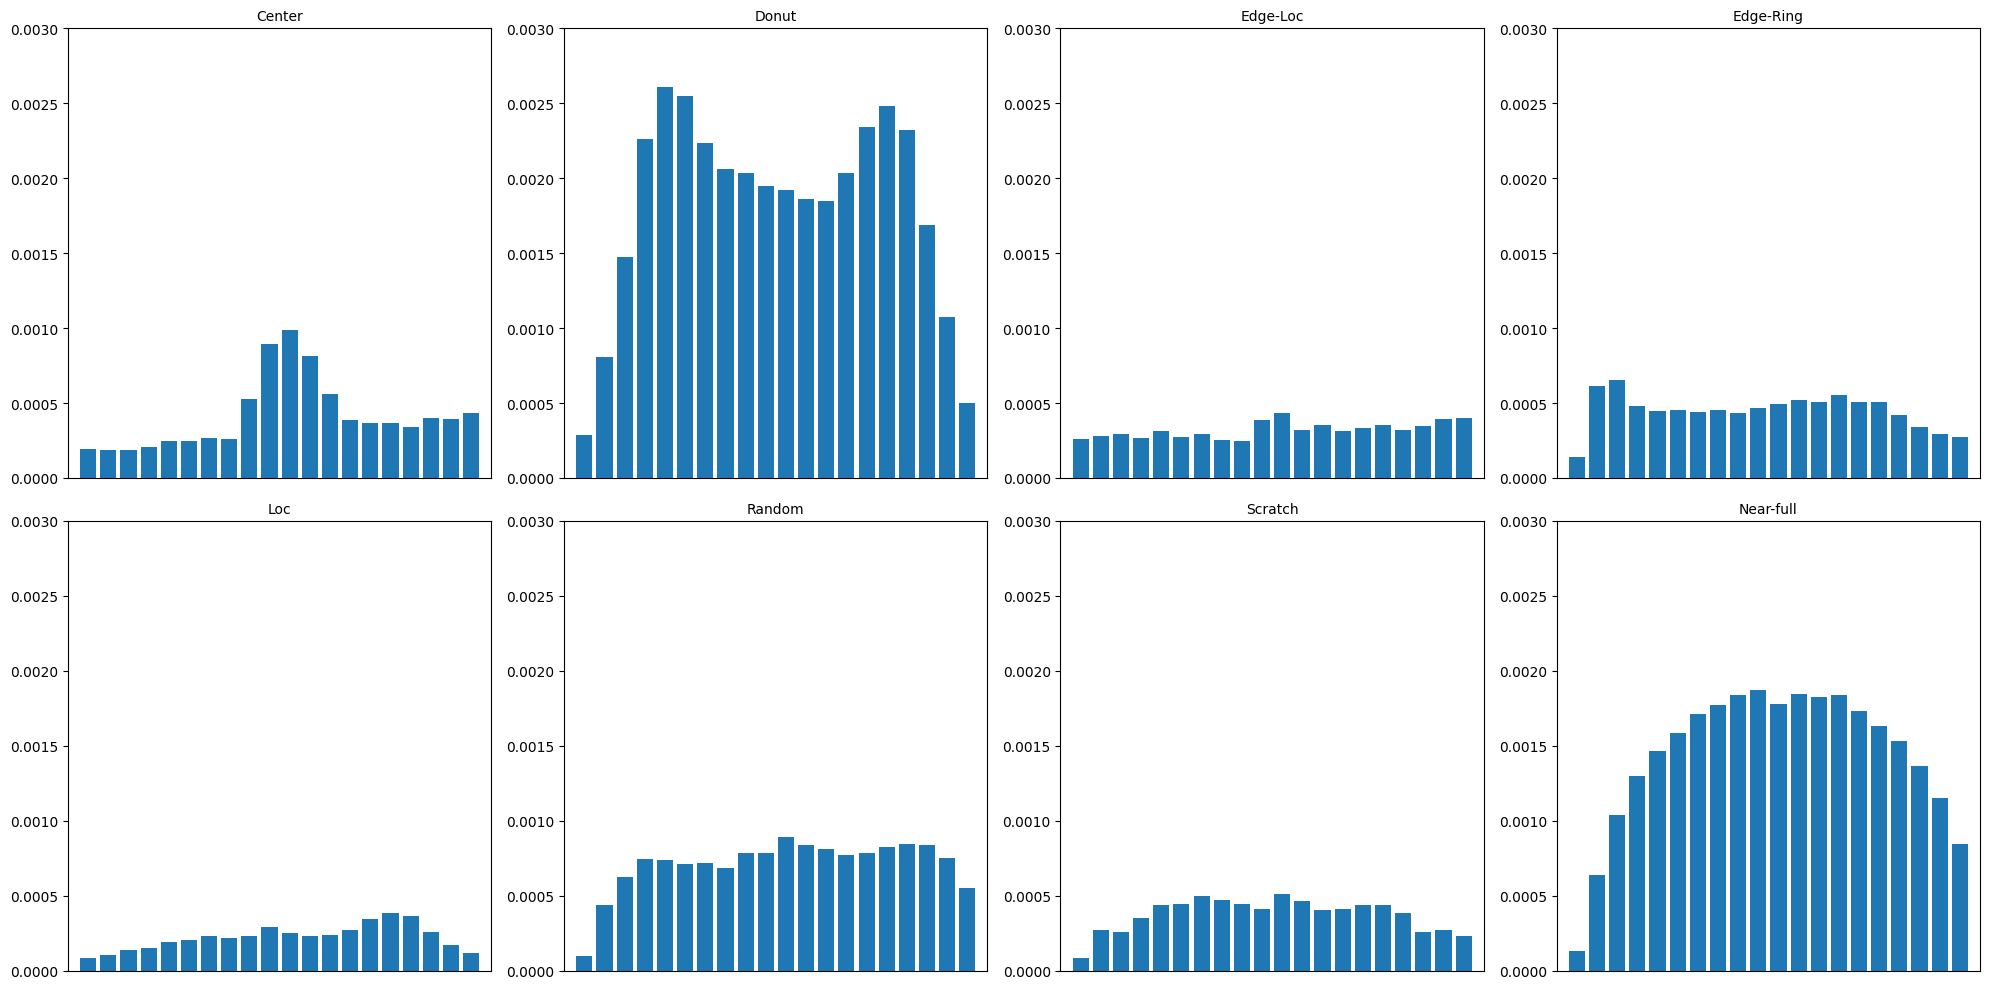

In [75]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_mean[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,0.003])
plt.tight_layout()
plt.show() 

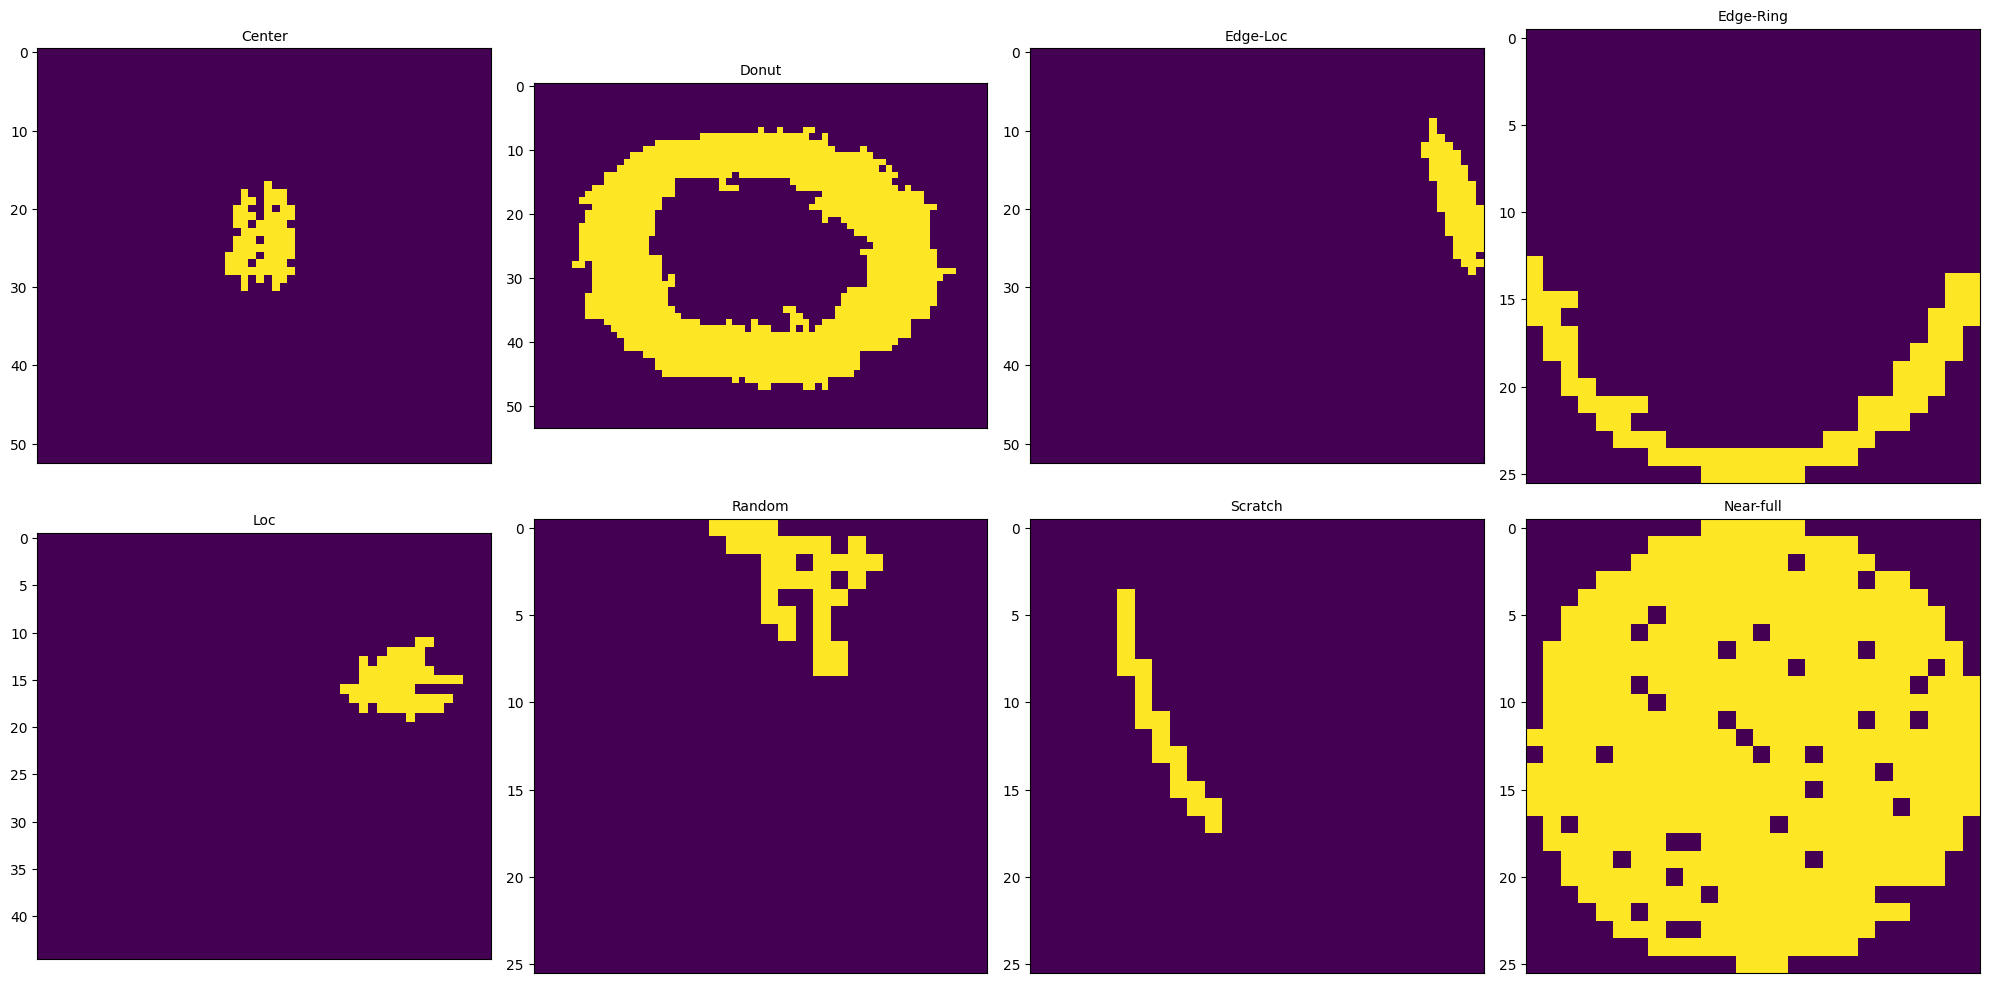

In [76]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    zero_img = np.zeros(img.shape)
    img_labels = measure.label(img, connectivity=1, background=0)
    img_labels = img_labels-1
    if img_labels.max()==0:
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>-1], axis = None)
        no_region = info_region[0]
    
    zero_img[np.where(img_labels==no_region)] = 2 
    ax[i].imshow(zero_img)
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show() 

In [ ]:
def cal_dist(img, x, y):
    dim0 = np.size(img, axis=0)
    dim1 = np.size(img, axis=1)
    dist = np.sqrt((x - dim0 / 2) ** 2 + (y - dim1 / 2) ** 2)
    return dist

def fea_geom(img):
    norm_area = img.shape[0] * img.shape[1]
    norm_perimeter = np.sqrt((img.shape[0]) ** 2 + (img.shape[1]) ** 2)
    
    img_labels = measure.label(img, connectivity=1, background=0)

    if img_labels.max() == 0:
        img_labels[img_labels == 0] = 1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels > 0], axis=None)
        if info_region.count.size > 0 and isinstance(info_region.mode, np.ndarray):
            no_region = info_region.mode[0] - 1
        else:
            return [0, 0, 0, 0, 0, 0]
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area / norm_area
    prop_perimeter = prop[no_region].perimeter / norm_perimeter
    
    prop_cent = prop[no_region].local_centroid
    prop_cent = cal_dist(img, prop_cent[0], prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length / norm_perimeter
    prop_minaxis = prop[no_region].minor_axis_length / norm_perimeter
    prop_ecc = prop[no_region].eccentricity
    prop_solidity = prop[no_region].solidity
    
    return prop_area, prop_perimeter, prop_majaxis, prop_minaxis, prop_ecc, prop_solidity

df_withpattern_copy['fea_geom'] = df_withpattern_copy.waferMap.apply(fea_geom)

In [86]:
df_withpattern_copy.fea_geom[340] #donut

[0, 0, 0, 0, 0, 0]

In [80]:
df_all=df_withpattern_copy.copy()
a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total

In [81]:
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

# 학습

In [82]:
X = fea_all
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                      
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42

Training target statistics: Counter({np.int64(3): 7299, np.int64(2): 3860, np.int64(0): 3238, np.int64(4): 2677, np.int64(6): 905, np.int64(5): 640, np.int64(1): 404, np.int64(7): 116})
Testing target statistics: Counter({np.int64(3): 2381, np.int64(2): 1329, np.int64(0): 1056, np.int64(4): 916, np.int64(6): 288, np.int64(5): 226, np.int64(1): 151, np.int64(7): 33})


In [83]:
# ---multicalss classification ---# 
# One-Vs-One
clf2 = OneVsOneClassifier(LinearSVC(random_state = RANDOM_STATE)).fit(X_train, y_train)
y_train_pred = clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)
train_acc2 = np.sum(y_train == y_train_pred, axis=0, dtype='float') / X_train.shape[0]
test_acc2 = np.sum(y_test == y_test_pred, axis=0, dtype='float') / X_test.shape[0]
print('One-Vs-One Training acc: {}'.format(train_acc2*100)) #One-Vs-One Training acc: 80.36
print('One-Vs-One Testing acc: {}'.format(test_acc2*100)) #One-Vs-One Testing acc: 79.04
print("y_train_pred[:100]: ", y_train_pred[:100])
print ("y_train[:100]: ", y_train[:100])

One-Vs-One Training acc: 71.92120800459793
One-Vs-One Testing acc: 71.99059561128527
y_train_pred[:100]:  [4 0 3 2 0 3 4 0 2 2 4 0 4 0 3 3 2 3 2 4 2 2 0 1 3 0 2 3 3 3 5 3 4 3 4 3 2
 4 3 2 2 0 3 3 0 4 3 5 2 2 0 3 3 3 3 0 3 3 4 0 4 3 3 3 3 3 4 3 0 3 2 4 0 4
 1 3 3 0 2 0 2 4 3 3 2 3 0 4 4 0 0 3 4 3 0 3 3 2 4 2]
y_train[:100]:  [5 0 4 2 0 3 2 0 2 2 6 0 4 0 3 0 6 2 2 5 2 4 0 5 3 0 3 3 3 3 2 3 4 3 4 3 3
 4 3 2 2 3 3 3 0 6 3 5 2 3 0 3 2 2 2 0 3 3 1 0 4 2 3 3 3 3 4 3 0 3 2 4 0 4
 2 3 3 0 2 0 2 4 3 3 4 3 0 0 6 0 0 3 4 3 0 3 3 2 4 2]


In [84]:
def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

Confusion matrix, without normalization
Normalized confusion matrix


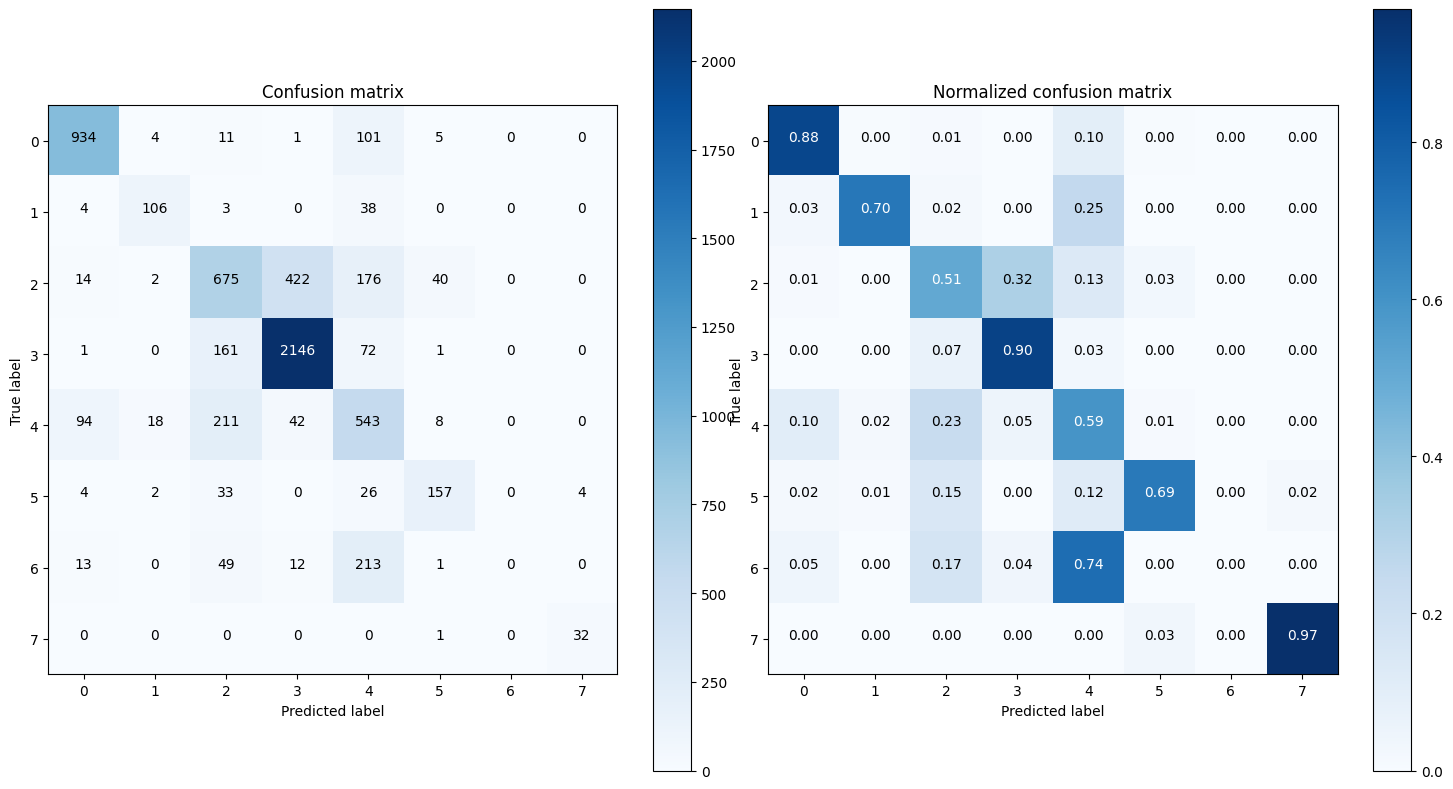

In [85]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()